### Natural Language processing (NLP)

Political Bias Detection with English dataset (labeled_dataset_english.csv)

left: "Biased left" (0), central : "Neutral"(1), right: "biased right"(2)

In [1]:

import matplotlib.pyplot as plt
import seaborn as sns

#NLP libraries
import nltk
from gensim.models import Doc2Vec
import gensim
from gensim.models.doc2vec import TaggedDocument

#Machine learning libraries
from sklearn import utils
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

#Helper libraries
import multiprocessing
import numpy as np
import pandas as pd
import math
from bs4 import BeautifulSoup
import re
import os


nltk.download('punkt', download_dir="./data_model/")
nltk.download("stopwords", download_dir="./data_model/")
nltk.data.path.append(os.path.abspath("./data_model/"))

[nltk_data] Downloading package punkt to ./data_model/...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to ./data_model/...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
dataset_eng= pd.read_csv("./data_model/labeled_dataset_english.csv", header=0, usecols=["Label_bias", "article", "type"])
#dataset_eng=dataset_eng[dataset_eng["Label_bias"]=="Biased"]
dataset_eng["type"]=dataset_eng["type"].replace(['left','center','right'],[0,1,2])
dataset_eng=dataset_eng.drop(["Label_bias"], axis=1)
dataset=dataset_eng.rename(columns={"type": "bias", "article": "content"})
#dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset = dataset.dropna()
print(len(dataset))
print(dataset.head(10))

1600
   bias                                            content
0     1  YouTube says no ‘deepfakes’ or ‘birther’ video...
1     0  FRISCO, Texas — The increasingly bitter disput...
2     0  Speaking to the country for the first time fro...
3     2  A professor who teaches climate change classes...
4     2  The left has a thing for taking babies hostage...
5     1  (Reuters) - The World Anti-Doping Agency on Tu...
6     0  In Barack Obama’s first term, the administrati...
7     2  Republicans should stop fighting amnesty, Pres...
8     1  Doctor's pro-vaccine TikTok went viral. Then c...
9     1  'Horrifying': Mass burial held for 2,411 fetal...


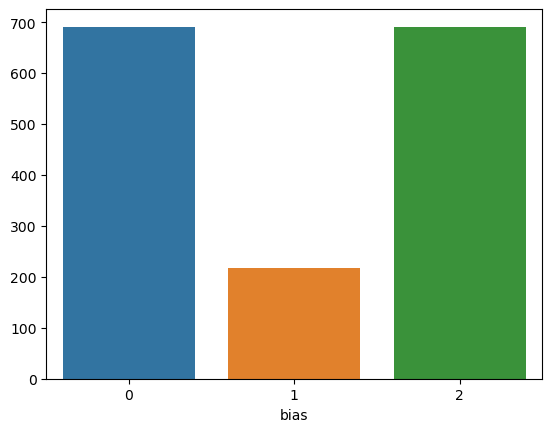

In [3]:
bias_vals = dataset['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

_stop word anglais


In [4]:
_stopwords = nltk.corpus.stopwords.words("english")

Cleaning dataset:


In [5]:
def clean(text):  #Removing unecessary punctuation and all lower case.
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r' ', text) 
    text = text.replace('„','')
    text = text.replace('“','')
    text = text.replace('"','')
    text = text.replace('\'','')
    text = text.replace('-','')
    text = text.lower()
    return text

def remove_stopwords(content):
    for word in _stopwords:
        content = content.replace(' '+word+' ',' ')
    return content

dataset['content'] = dataset['content'].apply(clean)
dataset['content'] = dataset['content'].apply(remove_stopwords)

C:\Users\Adrien\AppData\Local\Temp\ipykernel_20288\2298218591.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  text = BeautifulSoup(text, "lxml").text


Creating balanced train set

In [6]:
np.random.seed=10
a = len(dataset[dataset["bias"] == 1])

# Select rows for each class and combine them
indices = []

for bias_class in [0, 1, 2]:
    indices.extend(dataset[dataset["bias"] == bias_class].index[:a])

# Create the training dataset
train = dataset.loc[indices[:]]
train = train.iloc[np.random.permutation(len(train))]
train["bias"].value_counts()

bias
2    218
1    218
0    218
Name: count, dtype: int64

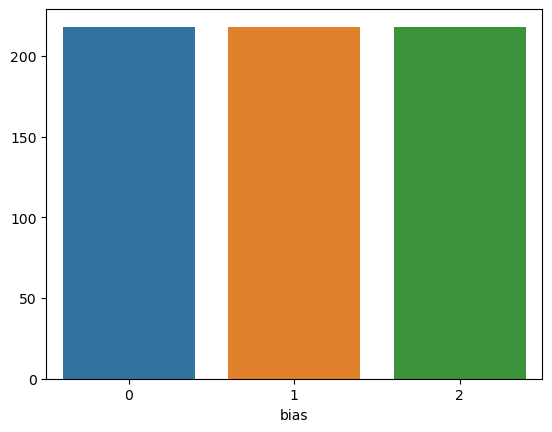

In [7]:
bias_vals = train['bias'].value_counts()
plt.figure()
sns.barplot(x=bias_vals.index, y=bias_vals.values)
plt.show()

In [8]:
test= dataset.copy().drop(indices)
test

,bias,content
541,0,huffpost part verizon media. partners store an...
543,0,get breaking news alerts special reports. news...
545,0,sports neutral. political battlefield. especia...
546,0,one biggest lies told many opponents immigrati...
550,0,huffpost part verizon media. partners store an...
...,...,...
1694,2,the house democrats’ coronavirus recovery bill...
1695,0,there many reasons republicans conservative ac...
1696,2,a man’s penis becomes female penis man declare...
1698,2,"as selfdescribed democratic socialist, sen. be..."


Transforming language to vectors
 

In [9]:
def tokenize_text(text):
    tokens = []
    for sent in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sent):
            if len(word) < 3:
                continue
            tokens.append(word.lower())
    return tokens

train_tagged = train.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=  [r.bias]), axis=1)
test_tagged = test.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['content']), tags=[r.bias]), axis=1)

PV-DBOW or PV-DM (PV-DBOW works better for short text, distributed bag of words)

In [11]:
cores = multiprocessing.cpu_count()
model = Doc2Vec(dm=0, vector_size=300, negative=5, hs=0, sample=0, min_count=2, workers=cores) # PV-DBOW


model.build_vocab(train_tagged.values)  #The model builds his vocabulary on the training set
model.train(utils.shuffle(train_tagged.values), #model train on a mixed trained values and 30 steps
total_examples=len(train_tagged.values),epochs=100)  

model.save("./data_model/doc2vec_articles_0.model")


Using trained model (PV-DBOW)

In [13]:
def vec_for_learning(model, tagged_docs):
    sents = tagged_docs.values
    classes, features = zip(*[(doc.tags[0],
      model.infer_vector(doc_words=doc.words, epochs=100)) for doc in sents]) #steps=epochs increase steps for better precision but more running time
    return features, classes

# PV_DBOW encoded text

train_x, train_y= vec_for_learning(model, train_tagged)
test_x, test_y = vec_for_learning(model, test_tagged)

### Classification methods : Naive Bayes, RandomForest, SVM, CNN ?

SVM parait bien dans le cas de classification de petits articles :

In [14]:
#Helper function for calculating accuracy on the test set.
def acc(true, pred):
  acc = 0
  for x,y in zip(true,pred):
    if(x == y): acc += 1
  return acc/len(pred)

In [16]:
svc_0 = SVC()

svc_0.fit(train_x,train_y)

svc_1 = SVC(probability=True)

svc_1.fit(train_x, train_y)

print(acc(test_y,svc_0.predict(test_x))) #Accuracy of model depending on know y_true and y_predict
print(acc(test_y,svc_1.predict(test_x)))

0.642706131078224
0.642706131078224


### Importing data from project to predict Political Bias

In [17]:
text_file_dir="./data/wikispeedia_articles_plaintext/plaintext_articles/"
file_data=[]

for filename in os.listdir(text_file_dir):
    with open(os.path.join(text_file_dir, filename), "r") as file:
        content = file.read()
    
        # Split the content into lines to remove the header
    lines = content.split('\n')

    #Removing the header (line 0)
    if lines:
        lines.pop(0)

    # Making it an array and removing all \n
    content = '\n'.join(lines)
    content = content.replace("\n", " ")


    new_file_content= {"text_content": content, "title": filename}
    
    file_data.append(new_file_content)

project_data = pd.DataFrame(file_data)

project_data

,text_content,title
0,Áedán mac Gabráin 2007 Schools Wikipedia Sel...,%C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt
1,Åland 2007 Schools Wikipedia Selection. Rela...,%C3%85land.txt
2,Édouard Manet 2007 Schools Wikipedia Selecti...,%C3%89douard_Manet.txt
3,Éire 2007 Schools Wikipedia Selection. Relat...,%C3%89ire.txt
4,Óengus I of the Picts 2007 Schools Wikipedia...,%C3%93engus_I_of_the_Picts.txt
...,...,...
4599,Zirconium 2007 Schools Wikipedia Selection. ...,Zirconium.txt
4600,Zoroaster 2007 Schools Wikipedia Selection. ...,Zoroaster.txt
4601,Zuid-Gelders 2007 Schools Wikipedia Selectio...,Zuid-Gelders.txt
4602,Zulu 2007 Schools Wikipedia Selection. Relat...,Zulu.txt


Cleaning the data and removing useless word for prediction

In [18]:
project_data['text_content'] = project_data['text_content'].apply(clean)
project_data['text_content'] = project_data['text_content'].apply(remove_stopwords)

Putting lowercase and tokenize the text

In [20]:
project_tagged = project_data.apply(
   lambda r: TaggedDocument(words=tokenize_text(r['text_content']), tags=  []), axis=1)

In [23]:
def vectorizing_project_data(model, tagged_docs):
    sents = tagged_docs.values
    features = [model.infer_vector(doc.words, epochs=20) for doc in sents]
    return features

project_vector=vectorizing_project_data(model, project_tagged)

Prediction of Classes:

In [24]:
prediction=svc_0.predict(project_vector)
print(np.unique(prediction))
print(len(project_data), len(prediction))
project_data["Bias"]=prediction

[0 1 2]
4604 4604


In [26]:
class_probabilities=svc_1.predict_proba(project_vector)

array([[0.01960629, 0.05505168, 0.92534203],
       [0.20669935, 0.11506767, 0.67823297],
       [0.47229799, 0.15311058, 0.37459143],
       ...,
       [0.04336977, 0.23803548, 0.71859474],
       [0.36045977, 0.18062381, 0.45891642],
       [0.71657022, 0.24757816, 0.03585162]])

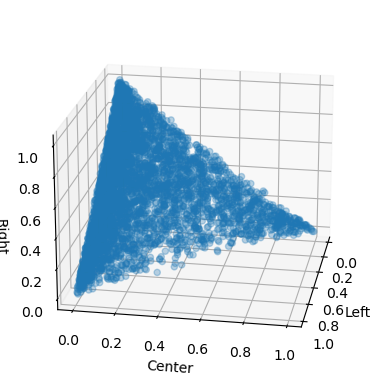

In [38]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import ipywidgets as widgets
from IPython.display import display


# Probability depend on class
x = class_probabilities[:,0]
y = class_probabilities[:,1]
z = class_probabilities[:,2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(azim=10, elev=20)

# Plot the data points as a 3D scatter plot
ax.scatter(x, y, z, alpha=0.3)

# Set labels for the axes
ax.set_xlabel('Left')
ax.set_ylabel('Center')
ax.set_zlabel('Right')

""" Ne marche pas pour l'instant
# Function to update the 3D plot based on angles
def update_plot(azimuth_angle, elevation_angle):
    ax.view_init(azim=azimuth_angle, elev=elevation_angle)
    fig.canvas.draw()

# Create interactive sliders for azimuth and elevation angles
azimuth_slider = widgets.FloatSlider(value=30, min=0, max=360, step=1, description='Azimuth:')
elevation_slider = widgets.FloatSlider(value=20, min=0, max=90, step=1, description='Elevation:')

# Create a callback function to update the plot when sliders change
def sliders_changed(change):
    update_plot(azimuth_slider.value, elevation_slider.value)

# Link sliders to the callback function
azimuth_slider.observe(sliders_changed, 'value')
elevation_slider.observe(sliders_changed, 'value')

# Display the sliders and the 3D plot
display(azimuth_slider)
display(elevation_slider)
"""
plt.show()

In [39]:
project_data["title"][project_data["Bias"]==2]

0       %C3%81ed%C3%A1n_mac_Gabr%C3%A1in.txt
1                             %C3%85land.txt
3                              %C3%89ire.txt
4             %C3%93engus_I_of_the_Picts.txt
5         %E2%82%AC2_commemorative_coins.txt
                        ...                 
4591                          Zhang_Qian.txt
4592                            Zheng_He.txt
4594                            Zimbabwe.txt
4600                           Zoroaster.txt
4601                        Zuid-Gelders.txt
Name: title, Length: 1677, dtype: object

In [40]:
project_data["title"][project_data["Bias"]==1]

7                 11th_century.txt
11                15th_century.txt
16      1755_Lisbon_earthquake.txt
18        1896_Summer_Olympics.txt
19                18th_century.txt
                   ...            
4580            Yungay%2C_Peru.txt
4583               Z%C3%BCrich.txt
4584            Zachary_Taylor.txt
4593               Ziad_Jarrah.txt
4598        Zion_National_Park.txt
Name: title, Length: 802, dtype: object

In [41]:
project_data["title"][project_data["Bias"]==0]

2       %C3%89douard_Manet.txt
8             12th_century.txt
14                16_Cygni.txt
15             16_Cygni_Bb.txt
21         1973_oil_crisis.txt
                 ...          
4596         Zinc_chloride.txt
4597               Zionism.txt
4599             Zirconium.txt
4602                  Zulu.txt
4603           ZX_Spectrum.txt
Name: title, Length: 2125, dtype: object

In [42]:
vis_pred=project_data["Bias"].value_counts()
vis_pred # Nombre d'articles classifiés 

Bias
0    2125
2    1677
1     802
Name: count, dtype: int64

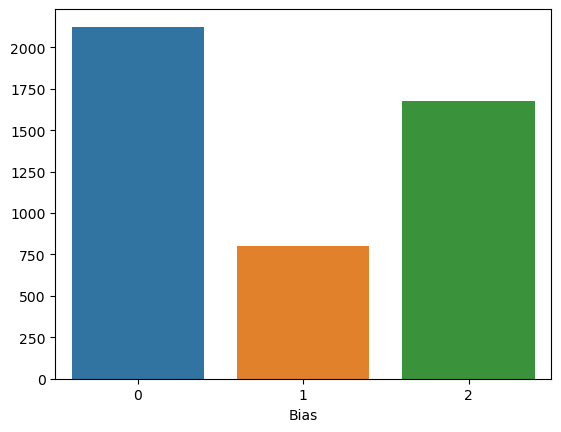

In [43]:
plt.figure()
sns.barplot(x=vis_pred.index, y=vis_pred.values)
plt.show()

In [44]:
proba=svc_0.decision_function(project_vector)
proba.shape

(4604, 3)

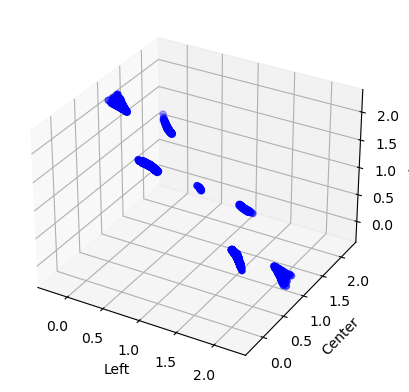

In [45]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Decision function
x = proba[:,0]
y = proba[:,1]
z = proba[:,2]

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data points as a 3D scatter plot
ax.scatter(x, y, z, c='b', marker='o')

# Set labels for the axes
ax.set_xlabel('Left')
ax.set_ylabel('Center')
ax.set_zlabel('Right')

# Show the 3D plot
plt.show()

In [46]:
project_data[project_data["title"]=="Portuguese_Communist_Party.txt"]

,text_content,title,Bias
3319,portuguese communist party 2007 schools wikip...,Portuguese_Communist_Party.txt,2
